In [29]:
import pandas as pd
import geopandas as gp
import skmob
from skmob.measures.individual import radius_of_gyration, number_of_locations
import random
from tqdm.notebook import tqdm
tqdm.pandas()
import math
import matplotlib.pyplot as plt
import seaborn as sns
import math
from shapely import Point
from statannotations.Annotator import Annotator
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':200})
sns.set_palette(sns.color_palette("colorblind"))


import sys
sys.path.append('..')

import attack

In [81]:
# load data
# freemove = gp.read_file("data/freemove/freemove_clustering_tfidf.geojson", geometry='geometry')
# freemove_private = gp.read_file("data/freemove/freemove_private_clustering_tfidf.geojson", geometry='geometry')
# freemove_500tessellation = gp.read_file("data/freemove/freemove_500tessellation_clustering_tfidf.geojson", geometry='geometry')
# freemove_private_500tessellation = gp.read_file("data/freemove/freemove_private_500tessellation_clustering_tfidf.geojson", geometry='geometry')

geolife_private = gp.read_file("data/geolife/geolife_private_clustering_tfidf.geojson", geometry='geometry')


clustering_results = {
    'freemove': freemove,
    'freemove_private': freemove_private,
    'freemove_500tessellation': freemove_500tessellation,
    'freemove_private_500tessellation': freemove_private_500tessellation,
    'geolife_private': geolife_private,
}

In [17]:
attack.evaluate(freemove_private_500tessellation.clustering_HL.tolist(), freemove_private_500tessellation)

Homogeneity: 0.833
Completeness: 0.687
V-measure: 0.753
Rand index: 0.978
ARI: 0.398
MI: 3.272
NMI: 0.753
AMI: 0.538
Cluster accuracy: 0.442


In [42]:
def compute_perf_scores(clustering_result_data, uid, n_points):
    # get for random points from this user's trajectories
    coords = [list(x.coords) for x in clustering_result_data.query('PERSON_ID == @uid').geometry.tolist()]
    coords = [item for sublist in coords for item in sublist]
    rand_points = random.choices(coords, k=n_points)

    # find all trajectories where these points are part of and get unique cluster ids
    clustering_result_data['contains_rand_points'] = clustering_result_data.geometry.apply(lambda x: 1 if len(set(x.coords).intersection(set(rand_points))) > 0 else 0)
    cluster_ids = clustering_result_data.query('contains_rand_points == 1').clustering_HL.unique()

    # get trips of cluster and the true nr of trips of this user
    cluster_trips = clustering_result_data.query('clustering_HL in @cluster_ids')
    n_cluster_trips = len(cluster_trips)
    n_cluster_user_trips = len(cluster_trips.query('PERSON_ID == @uid'))
    n_user_trips = len(clustering_result_data.query('PERSON_ID == @uid'))

    # calculate precision, recall, mean
    precision = n_cluster_user_trips/n_cluster_trips
    recall = n_cluster_user_trips/n_user_trips
    pr_mean = (precision + recall)/2

    return precision, recall, pr_mean


def evaluate_attack(clustering_result_data, n_draws_per_user, nr_points):
    eval_scores = {'user_id': [], 'precision': [], 'recall': [], 'pr_mean': [], 'nr_points': []}
    
    # Find user ids that have at least N_POINTS + 1 trips
    user_ids = clustering_result_data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().query('TRIP_ID > @N_POINTS').PERSON_ID.unique()
    print('Nr of users to evaluate: ', user_ids.size)
    
    # only evaluate user that have at least N_POINTS/2 + 1 trips
    for uid in tqdm(user_ids):
    
        precision_scores, recall_scores, pr_mean_scores = [], [], []
        for i in range(n_draws_per_user):
            p, r, m = compute_perf_scores(clustering_result_data, uid, nr_points)
            precision_scores.append(p)
            recall_scores.append(r)
            pr_mean_scores.append(m)

        eval_scores['user_id'].extend([uid] * len(precision_scores))
        eval_scores['precision'].extend(precision_scores)
        eval_scores['recall'].extend(recall_scores)
        eval_scores['pr_mean'].extend(pr_mean_scores)
        eval_scores['nr_points'].extend([nr_points] * len(precision_scores))

    return pd.DataFrame.from_dict(eval_scores)

scores = []
for name, data in clustering_results.items():
    scores_points = []
    for nr_p in [1,4,10]:
        scores_points.append(evaluate_attack(data, n_draws_per_user=10, nr_points=nr_p))
    scores.append(pd.concat(scores_points))
    
scores = pd.concat(scores, keys=list(clustering_results.keys())).reset_index(0, names="data")

Nr of users to evaluate:  54


  0%|          | 0/54 [00:00<?, ?it/s]

Nr of users to evaluate:  54


  0%|          | 0/54 [00:00<?, ?it/s]

Nr of users to evaluate:  54


  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='nr_points', ylabel='pr_mean'>

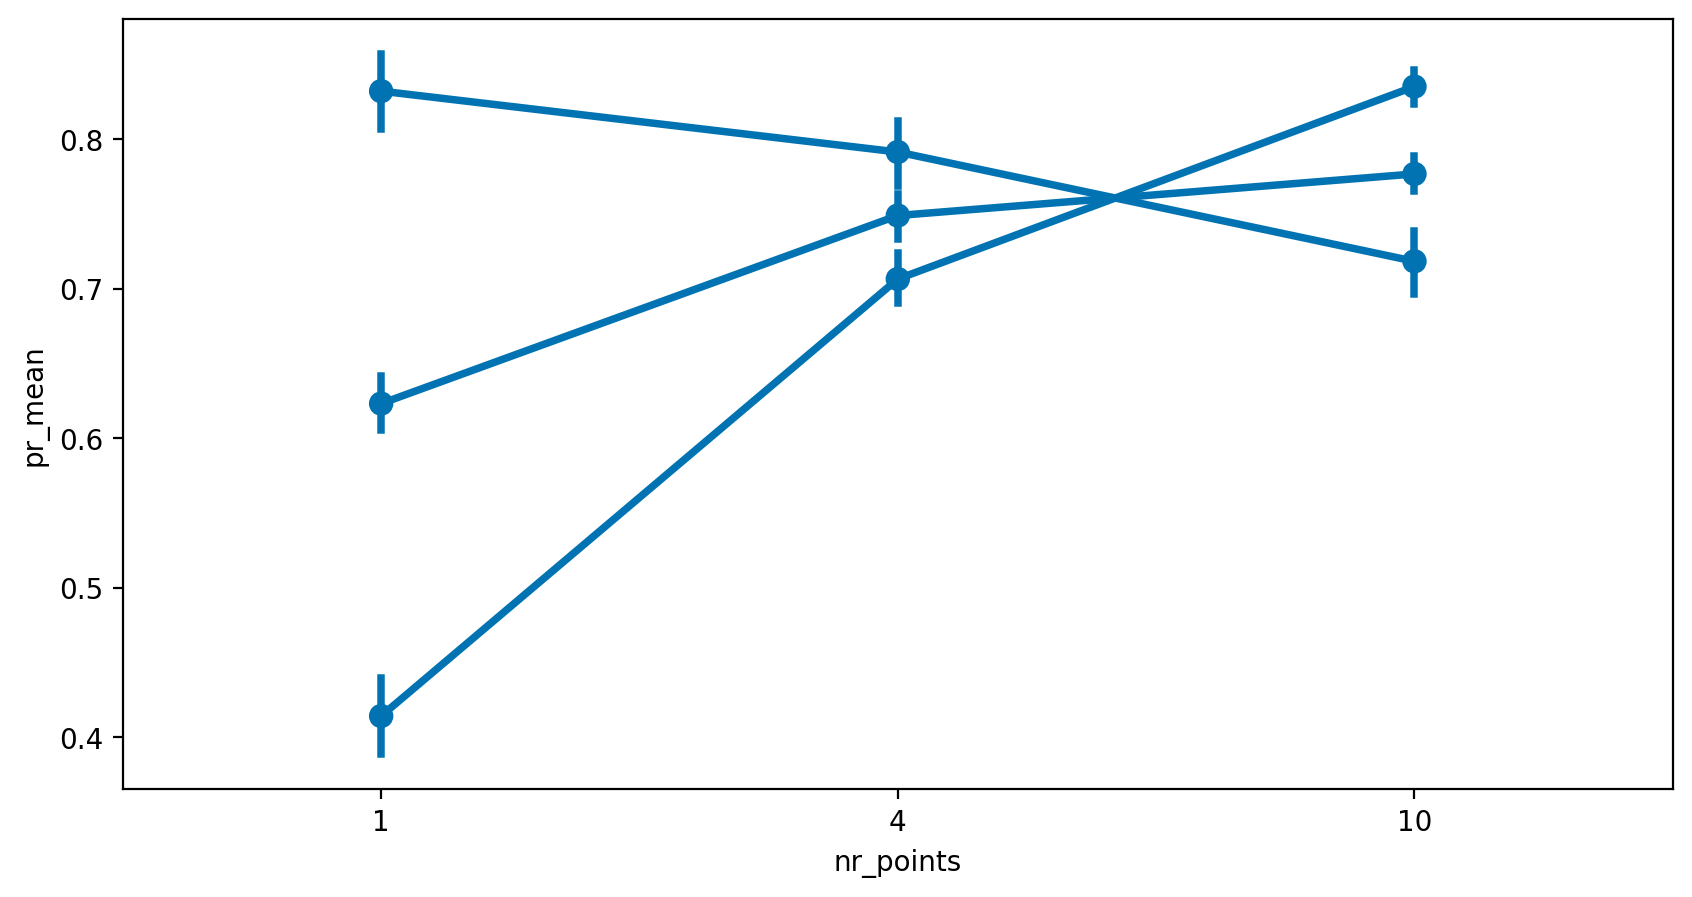

In [82]:
sns.pointplot(x="nr_points", y="precision", data=pd.concat(scores))
sns.pointplot(x="nr_points", y="recall", data=pd.concat(scores))
sns.pointplot(x="nr_points", y="pr_mean", data=pd.concat(scores))


In [84]:
scores = pd.concat(scores)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [100]:
scores.loc[scores.nr_points == 4, 'quant'] = pd.qcut(scores.query('nr_points == 4').pr_mean, 5)

<Axes: xlabel='quant', ylabel='pr_mean'>

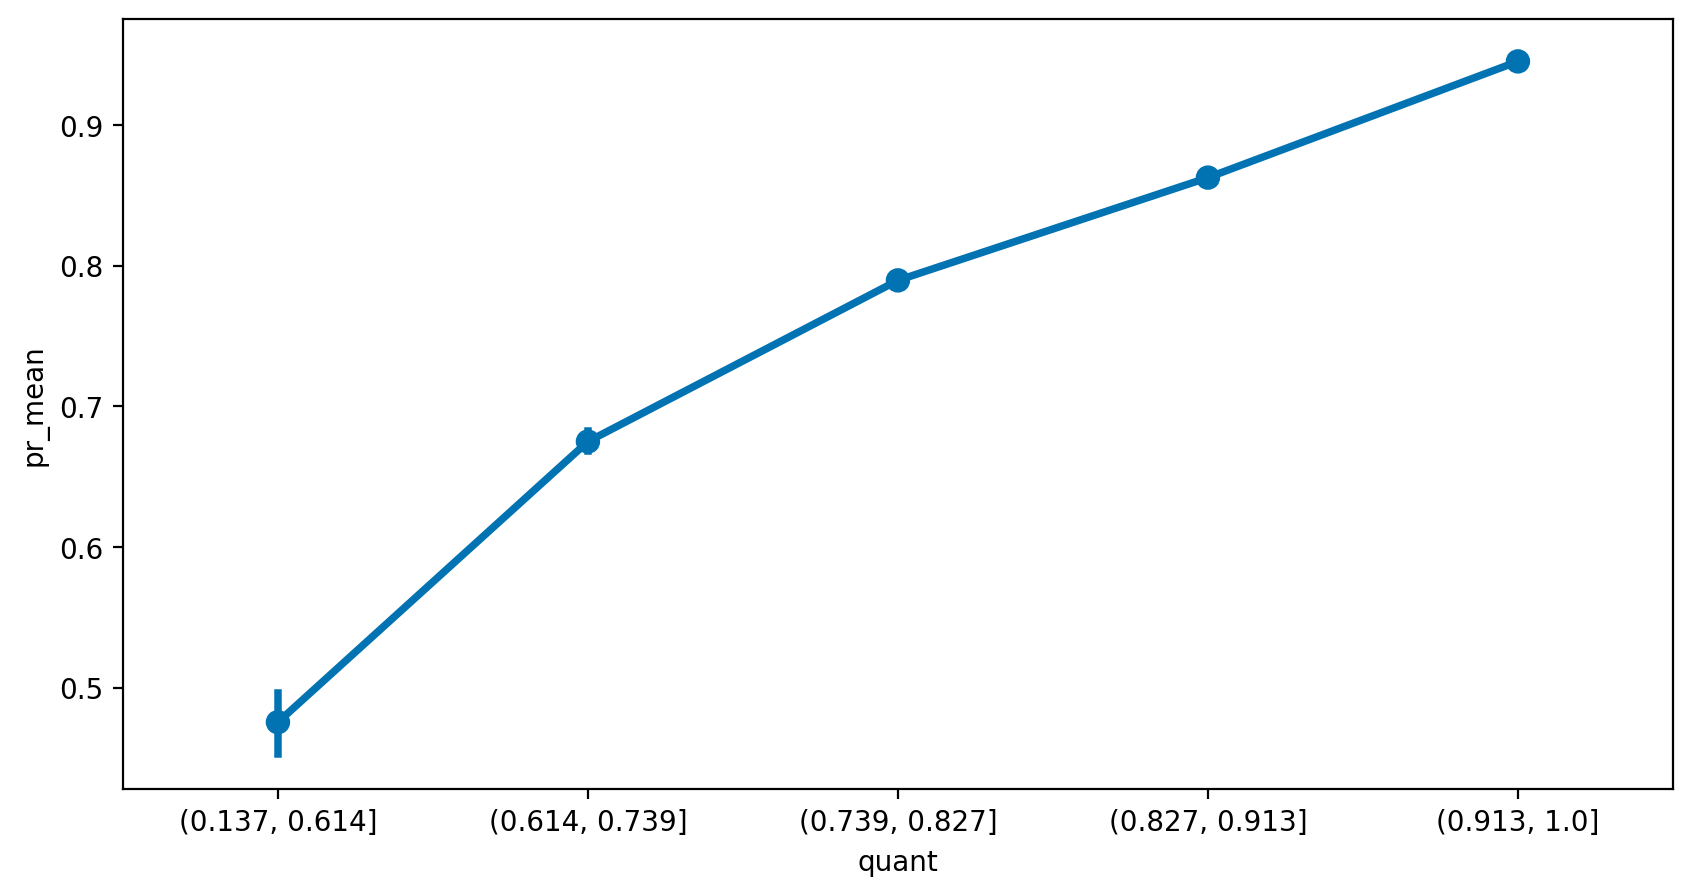

In [101]:
sns.pointplot(x="quant", y="pr_mean", data=scores.query('nr_points == 4'))